## EDA on beer review data set

In [74]:
## import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from scipy.stats import boxcox
%matplotlib inline

In [4]:
## Import the Data
data_path = '/Users/james/projects/ml_model_web/model_dev/data'
data_raw = pd.read_csv(data_path+'/raw/beer_reviews.csv')
data_raw.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [5]:
## What is the structure of the df
data_raw.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


In [6]:
print('The data has ', data_raw.shape[0],' rows')
print('The data has ', data_raw.shape[1],' columns')

The data has  1586614  rows
The data has  13  columns


In [7]:
# calculate the overall % of the number of null values for each feature in the df
print(data_raw.isnull().sum()/data_raw.shape[0]*100)
## require to drop the 4% of rows from the beer_abv columns with nan if it is to be used in the model

brewery_id            0.000000
brewery_name          0.000945
review_time           0.000000
review_overall        0.000000
review_aroma          0.000000
review_appearance     0.000000
review_profilename    0.021934
beer_style            0.000000
review_palate         0.000000
review_taste          0.000000
beer_name             0.000000
beer_abv              4.272306
beer_beerid           0.000000
dtype: float64


#### Finding
The beer_abv is missing 4.2% of values. 

In [8]:
print('The Data has the following Data types ' ,data_raw.dtypes.unique())

The Data has the following Data types  [dtype('int64') dtype('O') dtype('float64')]


In [78]:
## remove the rows that have nan values
df_nan_rem = data_raw.dropna(axis = 0, how = 'any')

In [79]:
#Extracting the object columns from the above dataframe

## Create a df with the data types

temp = pd.DataFrame(df_nan_rem.dtypes) # create the df
temp.columns = ['DataType'] # label the df column
temp

,DataType
brewery_id,int64
brewery_name,object
review_time,int64
review_overall,float64
review_aroma,float64
review_appearance,float64
review_profilename,object
beer_style,object
review_palate,float64
review_taste,float64


In [80]:
categorical_columns = temp.index[temp["DataType"] == 'O'].values
for column in categorical_columns:
    print(column+" column has :",str(len(data_raw[column].unique()))+" distinct values")

brewery_name column has : 5743 distinct values
review_profilename column has : 33388 distinct values
beer_style column has : 104 distinct values
beer_name column has : 56857 distinct values


#### Finding
The categorical columns have large numbers of distinct values - this is a decision on what kind of beer classifier do we want to/ need to create.

Is it just the beer style or a combination of the beer style with teh brewery name? 
One way to handle this is to encode the categorical variable that are not target varaibles with integers.

For teh purposes of the classification model will initially deliver only the beer style then the expanded model will deliver the beer style with teh brewery name based on the inputs. 

In [81]:
# Create a function that will create a dict for each of the categorical variables in a column with a sequential integer
def int_dict(x):
    """ This function takes a categorical list and turns it into a dictionary with a 
    corresponding integer for a key.
    
    It is intended to be used for modelling purposes as part of Data preparation to avoid
    creating high dimensional one-hot encoded data sets for modelling """
    list_x = x.unique()
    d = dict.fromkeys(list_x)
    counter = 0
    for v in d:
        counter = counter + 1
        d[v]=counter
    return(d)

In [82]:
# Save the target
tgt = df_nan_rem['beer_style']
tgt.to_csv('/Users/james/projects/ml_model_web/model_dev/data/holding/tgt.csv', index = False)

In [83]:
## Gather the Data to be used to build the model

preds = ['review_overall', 'review_aroma', 'review_appearance','review_palate', 'review_taste', 'beer_abv']
df_nan_rem[preds].to_csv('/Users/james/projects/ml_model_web/model_dev/data/holding/preds.csv', index = False)

<AxesSubplot:xlabel='review_overall', ylabel='Count'>

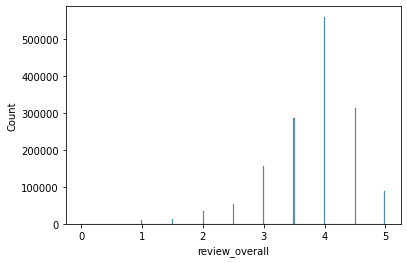

In [84]:
sns.histplot(df_nan_rem['review_overall'])

<Figure size 432x288 with 0 Axes>

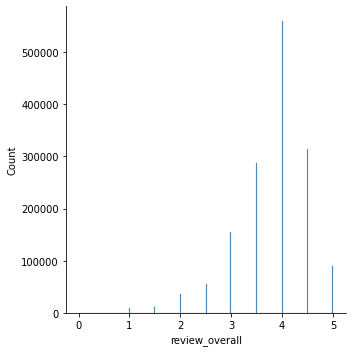

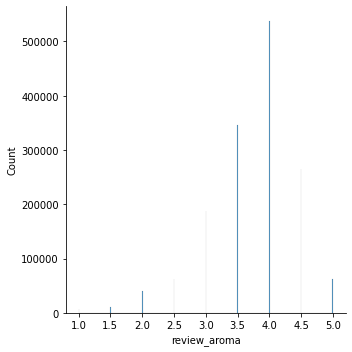

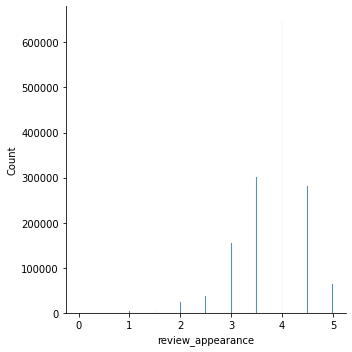

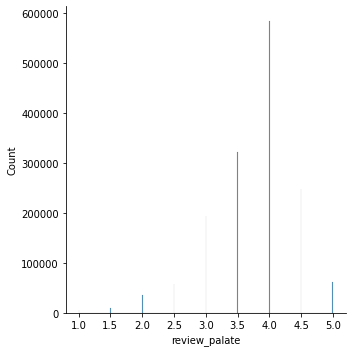

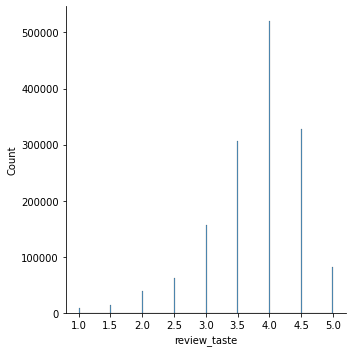

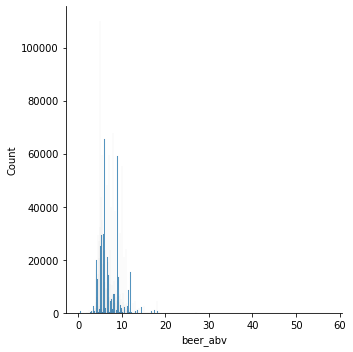

In [85]:
## Check the distribution for each of the intended variables 
for i, col in enumerate(df_nan_rem[preds]):
    plt.figure(i)
    sns.displot(df_nan_rem[col])

In [165]:
df_brew_count = pd.DataFrame(data_raw.value_counts(['brewery_name'])).reset_index()
col_names = ['brewery_name', 'count']
df_brew_count.columns = col_names
df_brew_count

,brewery_name,count
0,Boston Beer Company (Samuel Adams),39444
1,Dogfish Head Brewery,33839
2,Stone Brewing Co.,33066
3,Sierra Nevada Brewing Co.,28751
4,"Bell's Brewery, Inc.",25191
...,...,...
5737,Science Infuse,1
5738,Bir&#371; Alus,1
5739,Birrificio Valscura,1
5740,Calwer-Eck-Bräu GmbH & Co. KG,1


In [181]:
df_brew_count.iloc[:1000].sum()

brewery_name    Boston Beer Company (Samuel Adams)Dogfish Head...
count                                                     1479987
dtype: object

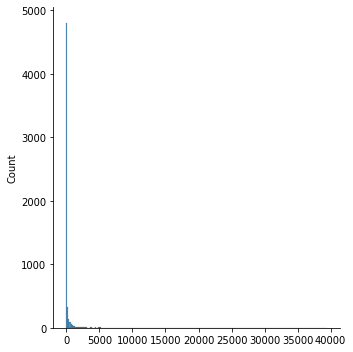

In [153]:
sns.displot(data_raw.value_counts(['brewery_name']), bins = 250)

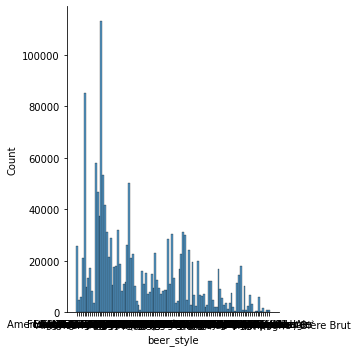

In [117]:
sns.displot(tgt)

#### Finding

The majority of the values intended to be used for the prediction are skewed - check in detail with the .skew() function

In [111]:
df_nan_rem[preds].skew() ## All of the variables are skewed to the left except the abv which is highly skewed to the right. 

review_overall      -1.029779
review_aroma        -0.851242
review_appearance   -0.910051
review_palate       -0.876648
review_taste        -0.983882
beer_abv             1.543499
dtype: float64

In [113]:
df_preds = df_nan_rem[preds]
df_preds

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
0,1.5,2.0,2.5,1.5,1.5,5.0
1,3.0,2.5,3.0,3.0,3.0,6.2
2,3.0,2.5,3.0,3.0,3.0,6.5
3,3.0,3.0,3.5,2.5,3.0,5.0
4,4.0,4.5,4.0,4.0,4.5,7.7
...,...,...,...,...,...,...
1586609,5.0,4.0,3.5,4.0,4.0,5.2
1586610,4.0,5.0,2.5,2.0,4.0,5.2
1586611,4.5,3.5,3.0,3.5,4.0,5.2
1586612,4.0,4.5,4.5,4.5,4.5,5.2


In [114]:
from sklearn.preprocessing import PowerTransformer 
pt = PowerTransformer(method = 'yeo-johnson')
preds_trans = pt.fit_transform(df_preds) 
df_preds_trans = pd.DataFrame(preds_trans, columns = df_preds.columns)

In [115]:
df_preds_trans.skew()

review_overall      -0.054989
review_aroma        -0.037140
review_appearance    0.002466
review_palate       -0.027319
review_taste        -0.069400
beer_abv            -0.041638
dtype: float64

In [ ]:
## Holding cell for code below

In [12]:
def cat_to_int(df):
    """ This function will determine the number of categories each of the categorical features has 
    in a df"""
    temp = pd.DataFrame(data_raw.dtypes) # create the df
    temp.columns = ['DataType'] # label the df column
    #print(temp)
    categorical_columns = temp.index[temp["DataType"] == 'O'].values
    for column in categorical_columns:
        print(column+" column has :",str(len(data_raw[column].unique()))+" distinct values")
    #print(df[categorical_columns].head())
    for column in df[categorical_columns]:
        #print(df[column])
        cat_dict = int_dict(df[column])
        #print(cat_dict)
        df = df.replace({column:cat_dict})
    return df

In [69]:
brew_name_ohe = pd.get_dummies(df_nan_rem['brewery_name'])

In [93]:
brew_name_cols = brew_name_ohe.columns


In [94]:
brew_name_cols

Index([''t Hofbrouwerijke', '(512) Brewing Company', '10 Barrel Brewing Co.',
       '1516 Brewing Company', '16 Mile Brewing Company',
       '1648 Brewing Company Ltd', '1702 / The Address Brewing Co.',
       '192 Brewing Company', '2 Brothers Brewery', '21st Amendment Brewery',
       ...
       'Åsundens Bryggeri', 'Ægir Bryggeri', 'Ölands Gårdsbryggeri',
       'Ölgerð Reykjavíkur', 'Ölgerðin Egill Skallagrímsson',
       'Ölvisholt Brugghús', 'Öufi Brauerei', 'Ølfabrikken', 'Ørbæk Bryggeri',
       'Łódzkie Browary S.A.'],
      dtype='object', length=5155)

In [78]:
# merge ohe brew names to the 'master'

df_nan_ohe = df_nan_rem.join(brew_name_ohe)


In [58]:
## Replace high dimensional data with an int from a generated dict from the custom function 
brew_name_dict = int_dict(df_nan_rem['brewery_name'])
brew_name_dict
df = df_nan_rem.replace({'brewery_name': brew_name_dict})
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,1,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,1,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,1,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,1,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,2,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,5142,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,5142,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,5142,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,5142,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [126]:
## Gather the Data to be used to build the model

preds = ['review_overall', 'review_aroma', 'review_appearance','review_palate', 'review_taste', 'beer_abv']
preds.extend(brew_name_cols)
preds
len(preds)

5161

In [116]:
df_preds_trans.to_csv('/Users/james/projects/ml_model_web/model_dev/data/holding/preds.csv', index = False)

In [109]:
# Save the target
tgt = df['beer_style']
tgt.to_csv('/Users/james/projects/ml_model_web/model_dev/data/holding/tgt.csv', index = False)

NameError: name 'df' is not defined

In [124]:
df_nan_ohe[preds].to_csv('/Users/james/projects/ml_model_web/model_dev/data/holding/preds.csv', index = False)

KeyboardInterrupt: 